In [59]:
import sys
sys.path.append("..")

import pandas as pd 
from channeling_lib import AWS_file_loader, save_figure, load_path, load_aws_calibration_data
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np


# Specify general folder:
aws_Cal_path = load_path()+'CalibratedData/AWS/'
arome_path = load_path()+ 'ModelOutput/AromeArctic/'


stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']
# FROM LOW TO HIGH

color_idx = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']


instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

In [2]:
# Load all AWS calibrated data
aws_Cal_data = load_aws_calibration_data(aws_Cal_path, stations_str)


In [43]:

dataset = xr.open_dataset(arome_path + 'AromeArctic_2p5km_20250125.nc')

# Display dataset information
dataset.air_temperature_2m.shape


(24, 17, 18)

In [ ]:
# # Load arome arctic data

# nc_files = sorted(glob.glob(os.path.join(arome_path, "AromeArctic*.nc")))

# # Load multiple NetCDF files into a single dataset
# aromeArctic_data = xr.open_mfdataset(nc_files, combine="by_coords")

# # Print dataset info
# print(aromeArctic_data.air_temperature_2m.shape)

# # print(aromeArctic_data.air_temperature_2m)

(408, 17, 18)


In [129]:

# Select the setup time for the station "Layla"
st = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == "Layla", "Setup time (UTC)"].values[0]
tt = instrument_textbook_data.loc[instrument_textbook_data["Station name"] == "Tom Joad", "Retrieval time (UTC)"].values[0]


print("Layla's Setup Time:", st)

print("Tom Joad Take down Time:", tt)


Layla's Setup Time: 1/26/25 11:25
Tom Joad Take down Time: 2/3/25 12:14


In [134]:
aromeArctic_data = xr.open_dataset(arome_path + 'AromeArctic_2p5km_MERGED_during_storm.nc', decode_coords='all')
aromeArctic_data = aromeArctic_data.sel(time=slice(st, tt))
# aromeArctic_data

In [ ]:
# # Get latitude and longitude for station "Layla"
# layla_data = instrument_textbook_data[instrument_textbook_data["Station name"] == "Layla"]

# # Extract values
# layla_lat = layla_data["LAT (dec deg)"].values[0]
# layla_lon = layla_data["LON (dec deg)"].values[0]

# print(f"Latitude: {layla_lat}, Longitude: {layla_lon}")


Latitude: 78.172686, Longitude: 16.010102


In [ ]:

# # Compute absolute difference
# abs_diff = np.abs(aromeArctic_data.latitude - layla_lat) + np.abs(aromeArctic_data.longitude - layla_lon)

# # Convert to NumPy array before applying argmin
# abs_diff_np = abs_diff.values  # Convert xarray DataArray to NumPy array

# # Find the nearest (y, x) index
# y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

# print(f"Nearest grid point for Layla: y={y_idx}, x={x_idx}")


Nearest grid point for Layla: y=7, x=10


In [117]:
# # Select a specific grid point (e.g., middle of the spatial grid)
# # temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=8, x=9)-273.15  # Adjust indices as needed
# # Convert Kelvin to Celsius by subtracting 273.15

# # Get latitude and longitude for station "Layla"
# layla_data = instrument_textbook_data[instrument_textbook_data["Station name"] == "Layla"]

# # Extract values
# layla_lat = layla_data["LAT (dec deg)"].values[0]
# layla_lon = layla_data["LON (dec deg)"].values[0]


# temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15
# temp_timeseries1 = aromeArctic_data.air_temperature_2m.interp(y=y_idx, x=x_idx, method="cubic") - 273.15 +3


# # Plot time series
# plt.figure(figsize=(10, 5))
# # plt.plot(aromeArctic_data.time, temp_timeseries, label="Temperature at nearest Grid Point", color='blue')
# plt.plot(aromeArctic_data.time, temp_timeseries1, label="Temperature interp", color='red')

# plt.xlabel("Time")
# plt.ylabel("Temperature (°C)")
# plt.title("Air Temperature at 2m Over Time")
# plt.legend()
# plt.grid()
# plt.show()


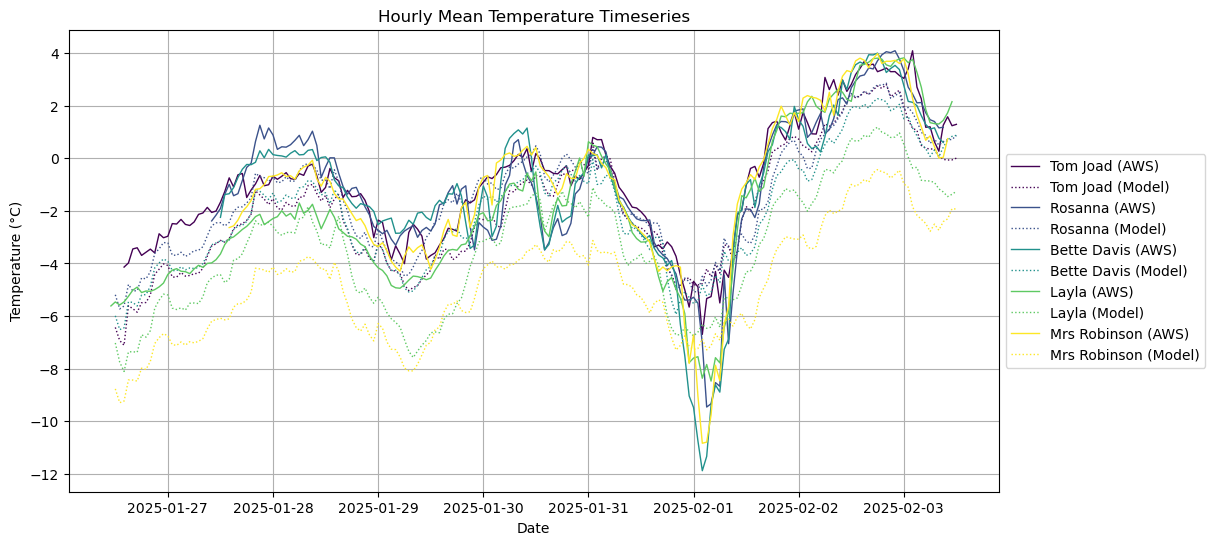

In [135]:
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each station to plot both AWS data and model data
for i, station in enumerate(stations_str):
    # Plot using hourly mean data from AWS
    aws_temp = aws_Cal_data[station].resample('h').mean()
    ax.plot(aws_temp.index, aws_temp.temperature, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15  # Convert Kelvin to Celsius
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, temp_timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')

ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title("Hourly Mean Temperature Timeseries")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
plt.show()

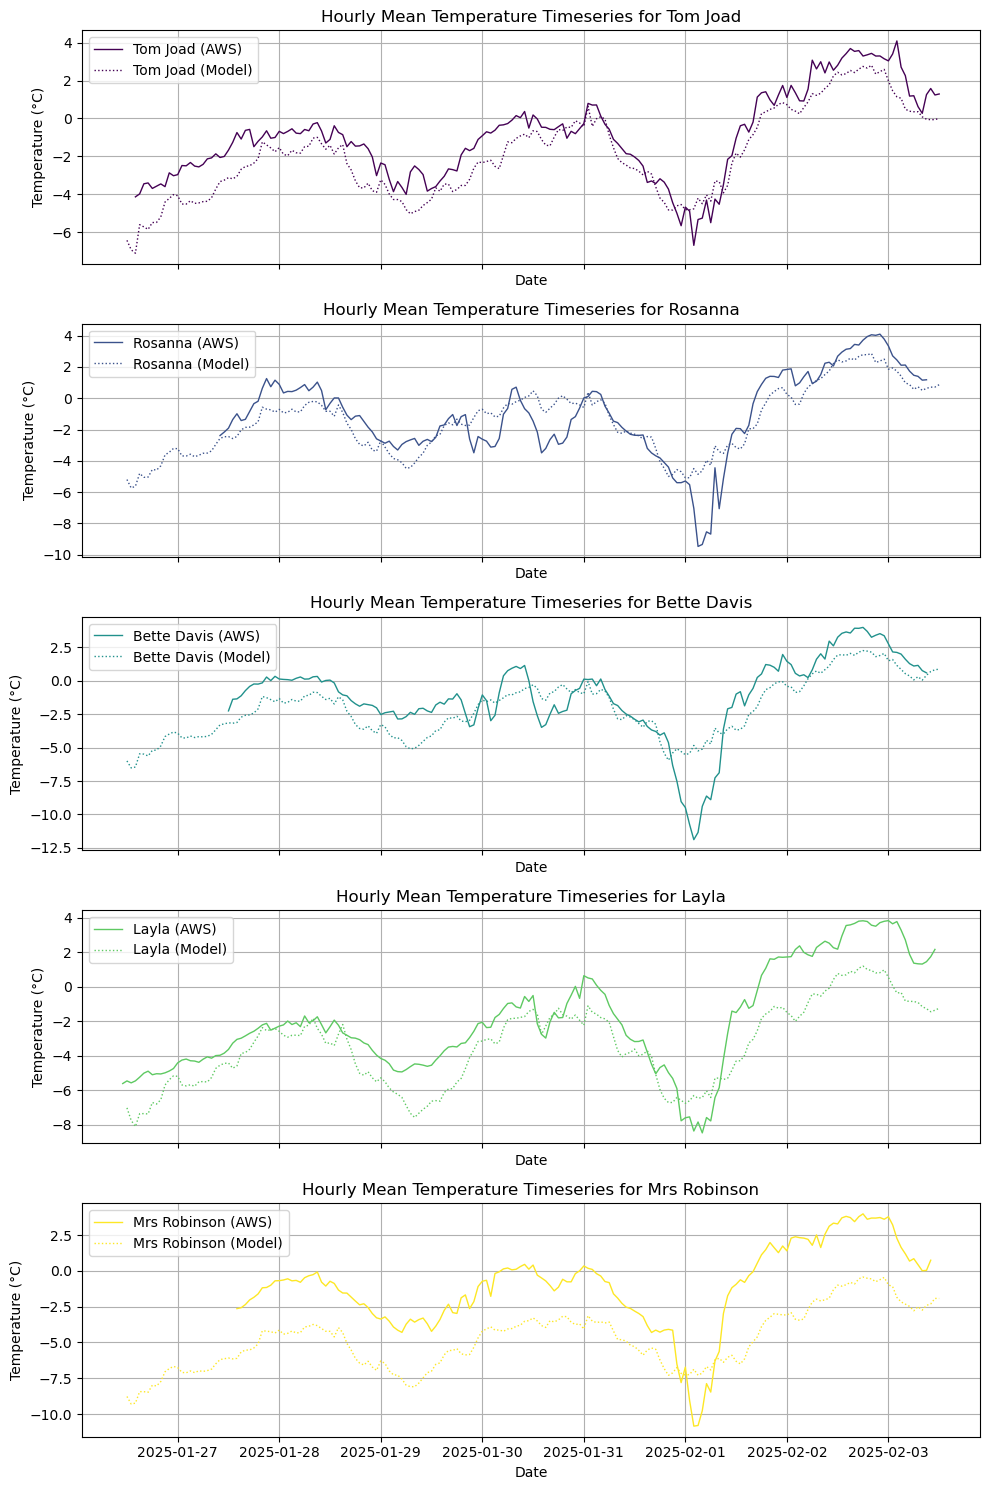

In [136]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    aws_temp = aws_Cal_data[station].resample('h').mean()
    ax.plot(aws_temp.index, aws_temp.temperature, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15  # Convert Kelvin to Celsius
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, temp_timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(f"Hourly Mean Temperature Timeseries for {station}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

In [175]:
stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']


aws_hourly_data = {}

for i, station in enumerate(stations_str):
    aws_hourly_data[station] = aws_Cal_data[station].resample('h').mean()
    # Add a column for station name
    aws_hourly_data[station]['Station'] = station   

# aws_hourly_data['Layla'].temperature



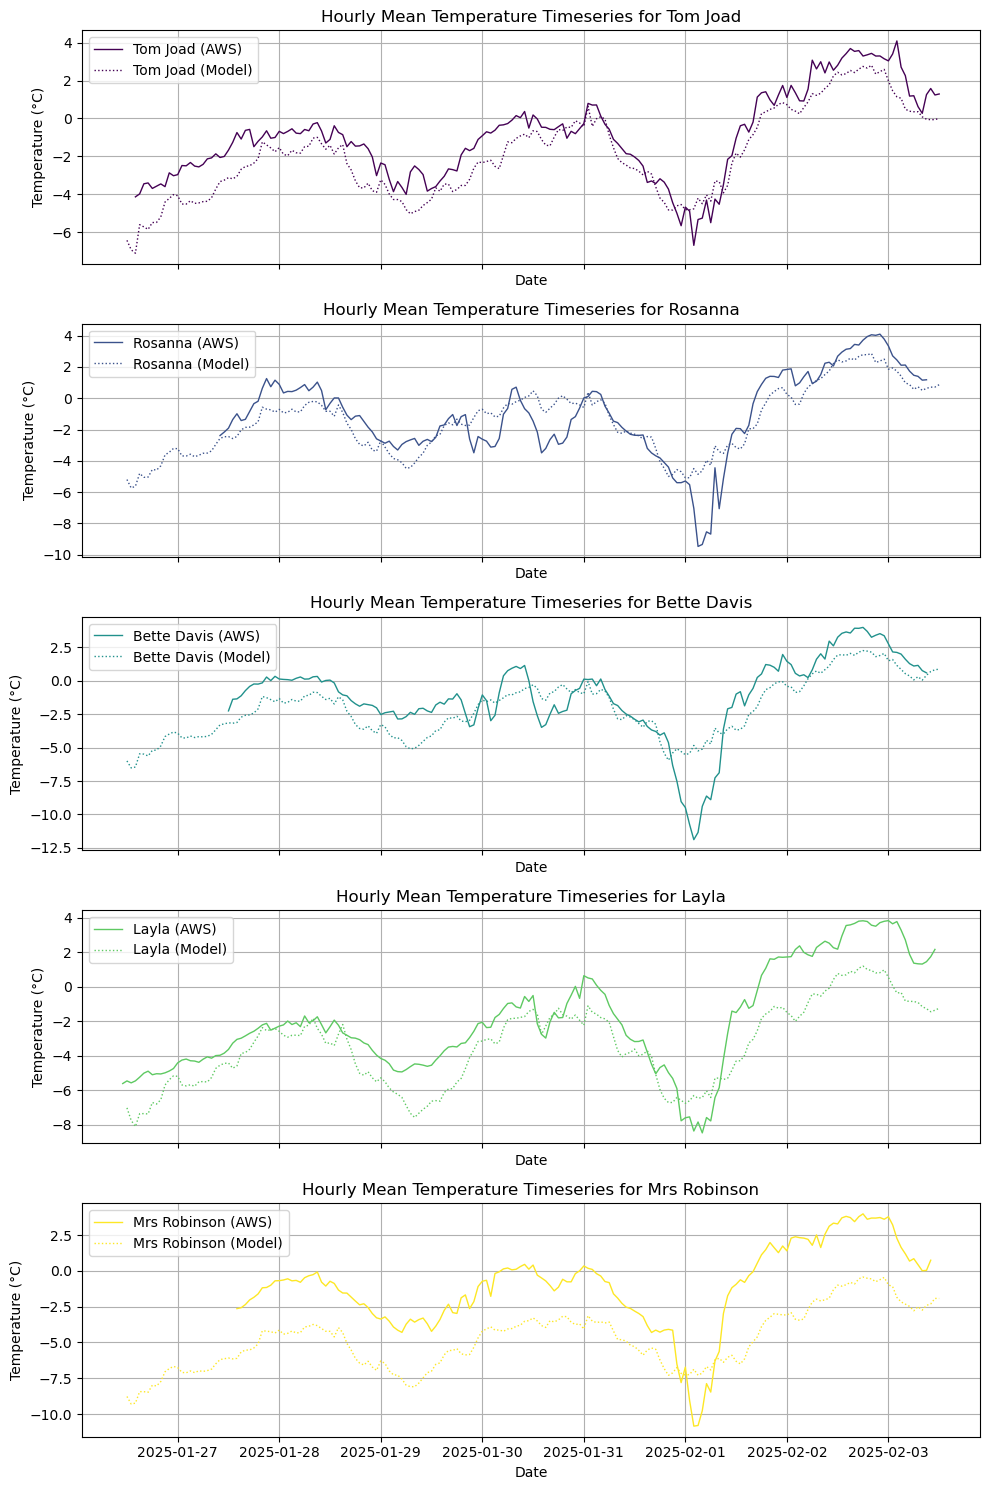

In [177]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].temperature, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    temp_timeseries = aromeArctic_data.air_temperature_2m.isel(y=y_idx, x=x_idx) - 273.15  # Convert Kelvin to Celsius
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, temp_timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(f"Hourly Mean Temperature Timeseries for {station}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

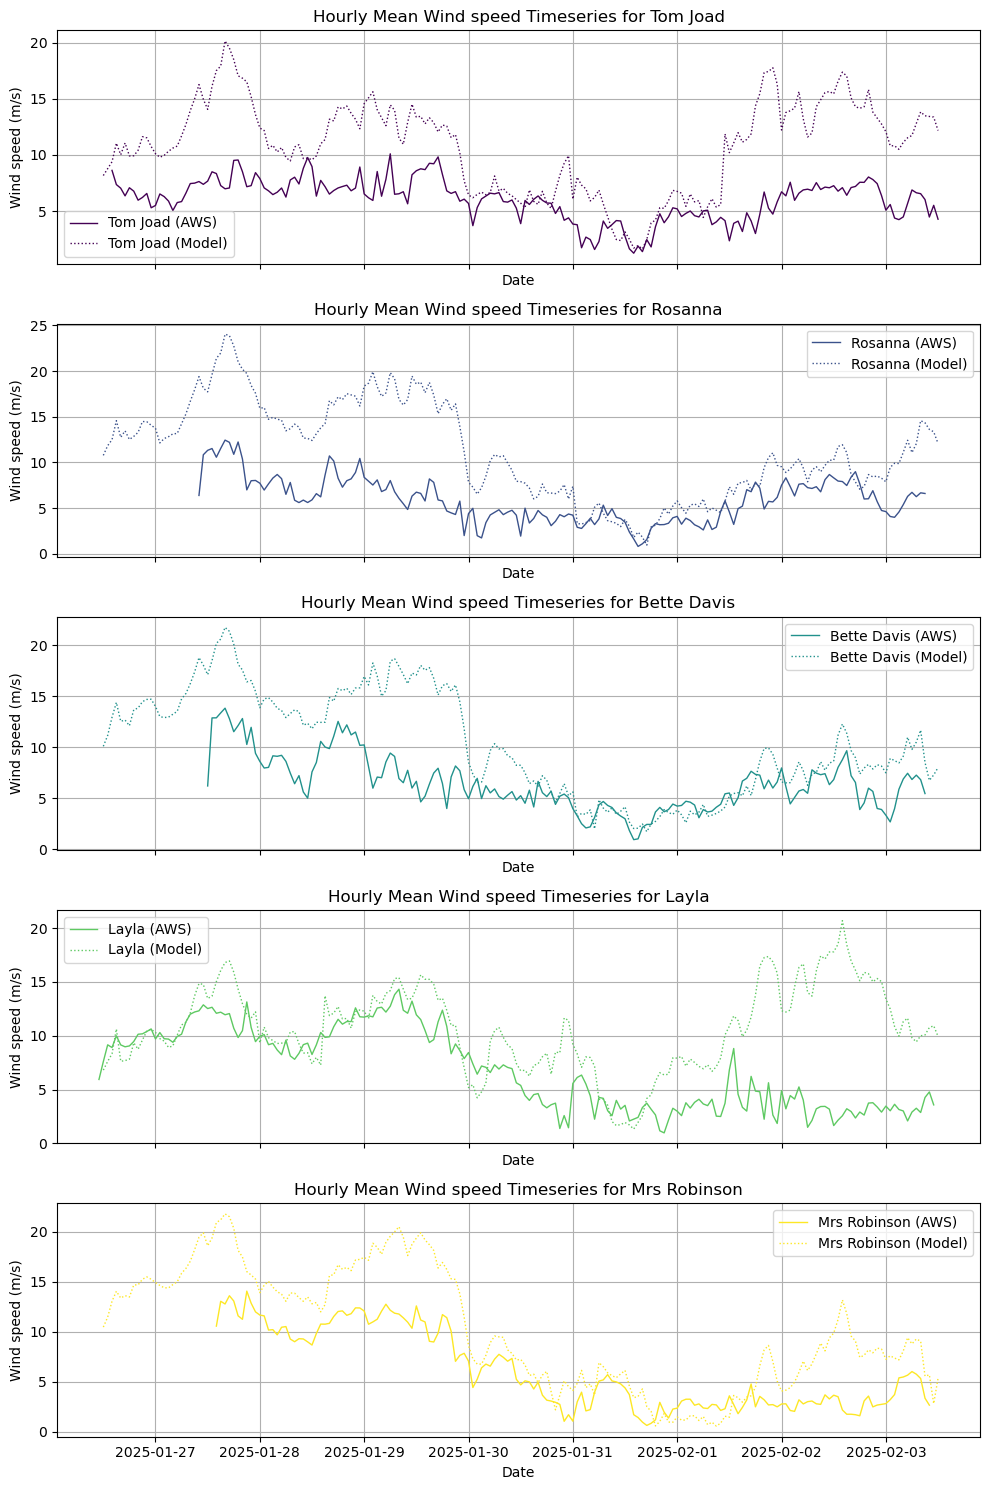

In [ ]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].calibrated_wind_speed, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    timeseries = aromeArctic_data.wind_speed_10m.isel(y=y_idx, x=x_idx)
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Wind speed (m/s)")
    ax.set_title(f"Hourly Mean Wind speed Timeseries for {station}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

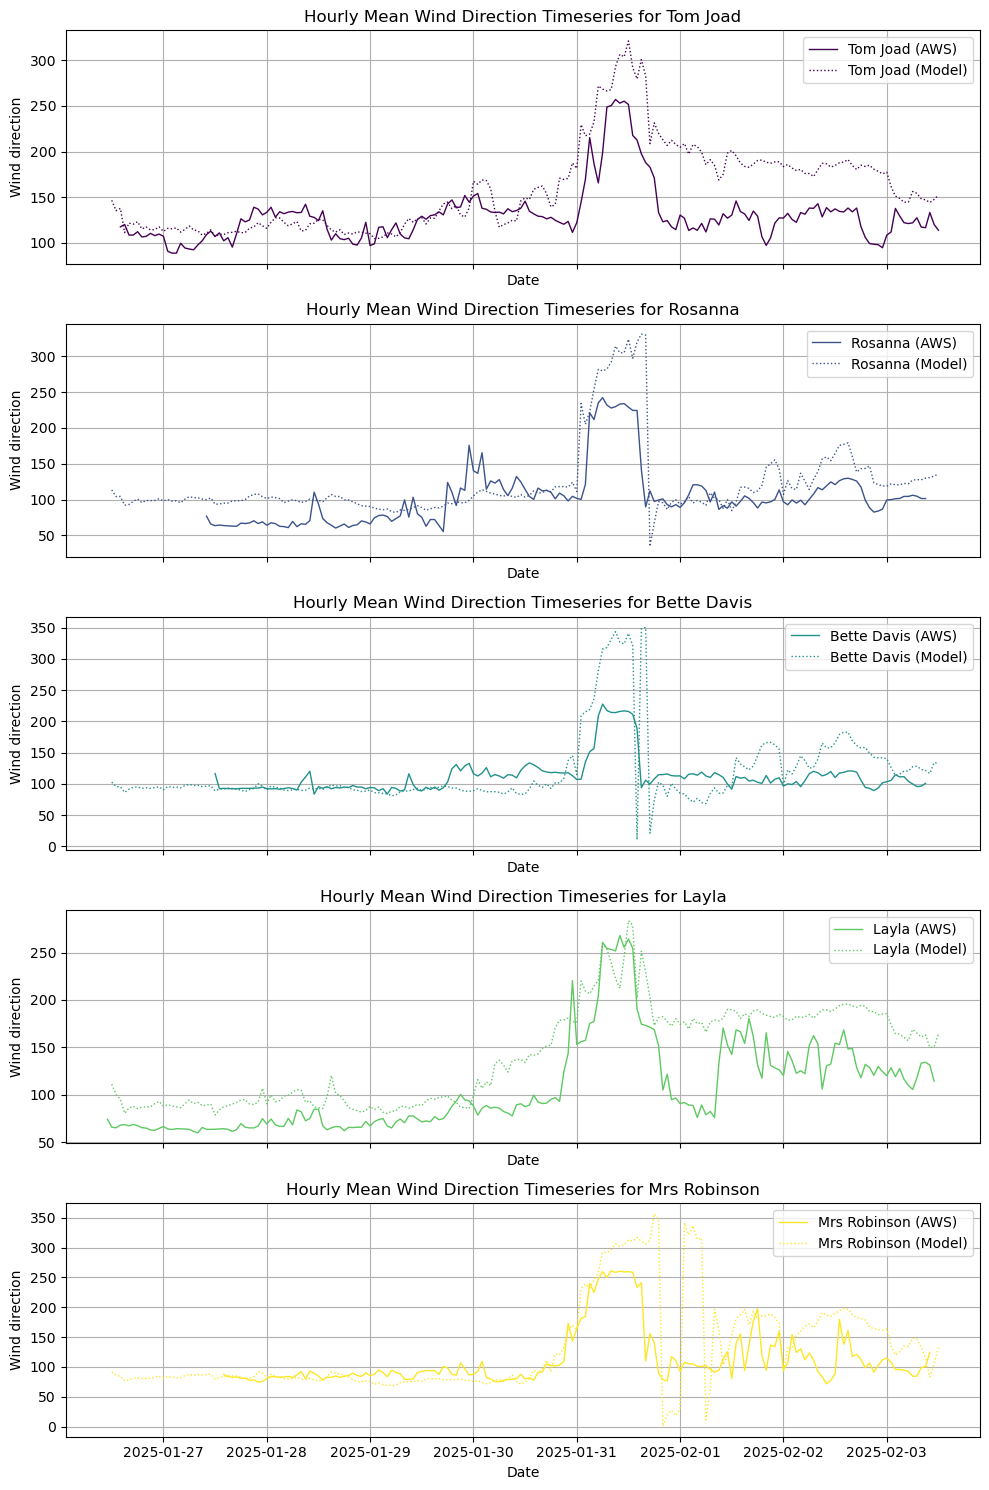

In [183]:
# Create subplots for each station
fig, axes = plt.subplots(len(stations_str), 1, figsize=(10, 3 * len(stations_str)), sharex=True)

for i, station in enumerate(stations_str):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].wind_direction, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    timeseries = aromeArctic_data.wind_direction_10m.isel(y=y_idx, x=x_idx)
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Wind direction")
    ax.set_title(f"Hourly Mean Wind Direction Timeseries for {station}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

In [194]:
aromeArctic_data

<xarray.Dataset> Size: 7MB
Dimensions:                                    (time: 193, y: 17, x: 18)
Coordinates:
  * time                                       (time) datetime64[ns] 2kB 2025...
    longitude                                  (y, x) float64 2kB 14.66 ... 1...
    latitude                                   (y, x) float64 2kB 78.18 ... 7...
  * x                                          (x) float32 72B 8.361e+05 ... ...
  * y                                          (y) float32 68B 3.695e+05 ... ...
    projection_lambert                         int32 4B ...
    height_above_msl                           float32 4B ...
Data variables: (12/25)
    air_temperature_2m                         (time, y, x) float32 236kB ...
    surface_air_pressure                       (time, y, x) float32 236kB ...
    air_temperature_0m                         (time, y, x) float32 236kB ...
    air_pressure_at_sea_level                  (time, y, x) float32 236kB ...
    cloud_area_fraction                        (time, y, x) float32 236kB ...
    atmosphere_boundary_layer_thickness        (time, y, x) float32 236kB ...
    ...                                         ...
    eastward_wind_10m                          (time, y, x) float64 472kB ...
    northward_wind_10m                         (time, y, x) float64 472kB ...
    wind_direction_10m                         (time, y, x) float64 472kB ...
    wind_speed_10m                             (time, y, x) float64 472kB ...
    air_potential_temperature_2m               (time, y, x) float32 236kB ...
    relative_humidty_2m                        (time, y, x) float32 236kB ...
Attributes: (12/44)
    CDI:                             Climate Data Interface version 2.4.0 (ht...
    Conventions:                     CF-1.6, ACDD-1.3
    source:                          Numerical Simulation
    institution:                     Norwegian Meteorological Institute (MET ...
    institution_short_name:          NO/MET
    min_time:                        2025-01-25T00:00:00Z
    ...                              ...
    title_no:                        Arome-Arctic 2.5Km deterministisk 2025-0...
    related_dataset:                 no.met:806070da-e9f3-4d03-ba1d-26b843961...
    summary:                         This file contains output from Control m...
    summary_no:                      Denne filen inneholder utdata fra kontro...
    DODS_EXTRA.Unlimited_Dimension:  time
    CDO:                             Climate Data Operators version 2.4.0 (ht...

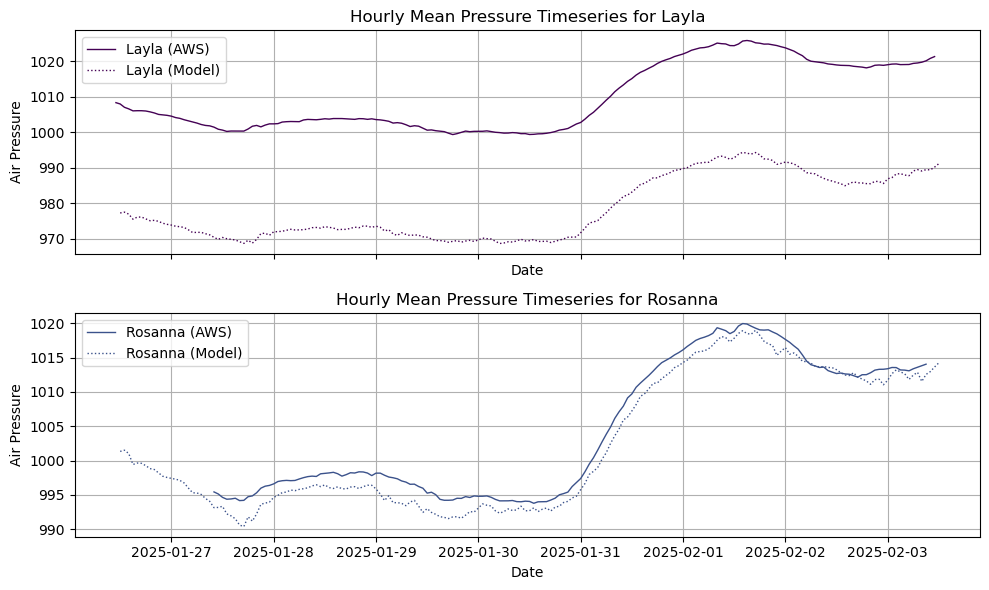

In [197]:
stations_to_plot = ["Layla", "Rosanna"]

# Create subplots for each station
fig, axes = plt.subplots(len(stations_to_plot), 1, figsize=(10, 3 * len(stations_to_plot)), sharex=True)

for i, station in enumerate(stations_to_plot):
    ax = axes[i]  # Get the corresponding subplot
    
    # Plot using hourly mean data from AWS
    ax.plot(aws_hourly_data[station].index, aws_hourly_data[station].calibrated_air_pressure, label=f'{station} (AWS)', linewidth=1, color=color_idx[i], linestyle='-')
    
    # Get latitude and longitude for the station
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]
    
    # Find the nearest grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values  # Convert to NumPy array
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
    
    # Extract the temperature time series from the model data
    timeseries = aromeArctic_data.surface_air_pressure.isel(y=y_idx, x=x_idx) / 100 #to go fro Pa to hPa
    
    # Plot model data with a dotted line in the same color
    ax.plot(aromeArctic_data.time, timeseries, label=f'{station} (Model)', linewidth=1, color=color_idx[i], linestyle='dotted')
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Air Pressure")
    ax.set_title(f"Hourly Mean Pressure Timeseries for {station}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()


